# Finding Anomalies in Stock Data

* Motivation:

Goldman Sachs has been involved in several insider trading scandals and the stock has been hit by it. The idea behind this EDA is to analyze the GS stock after the 2008 recession all the way until Jan 2013 with the objective of finding any anomalies in the stock behavior.

* Resources:
        
        *quantmod package R
        *NASDAQ earning dates reports
        *Obligatory insider trading reports from http://insidertrading.org/
        
* Methods:
        
        *Fast vs Slow Moving Average investment technique
        *Open Close and Open Open percentage change of the stock
        *Isolation Forest to identify outliers that might not be visible
        *Visualizations using the TTR and ggplot2 packages in R
        
* Objective:

Identify a subset of periods where the stock's behavior seems to be an anomaly and explain why it could be an anomaly. 

In [1]:
library(quantmod)
library(TTR)
library(tidyverse) 
library(dplyr)
library(ggplot2)
library(solitude)
library(devtools)
#install_github("braverock/blotter") # dependency
#install_github("braverock/quantstrat")
library(quantstrat)
library(huxtable)
library(repr)
options(repr.plot.width=15, repr.plot.height=8)

Loading required package: xts

Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Registered S3 method overwritten by 'xts':
  method     from
  as.zoo.xts zoo 

Loading required package: TTR

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

Version 0.4-0 included new data defaults. See ?getSymbols.

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──

✔ ggplot2 3.1.1       ✔ purrr   0.3.2  
✔ tibble  2.1.1       ✔ dplyr   0.8.0.1
✔ tidyr   0.8.3       ✔ stringr 1.4.0  
✔ readr   1.3.1       ✔ forcats 0.4.0  

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::first()  masks xts::first()
✖ dplyr::lag

In [2]:
options("getSymbols.warning4.0"=FALSE)
getSymbols(c("GS"))
GS_sub<-GS["2009-09/2013-01"]


[1] "GS"

Visualizing our Subset

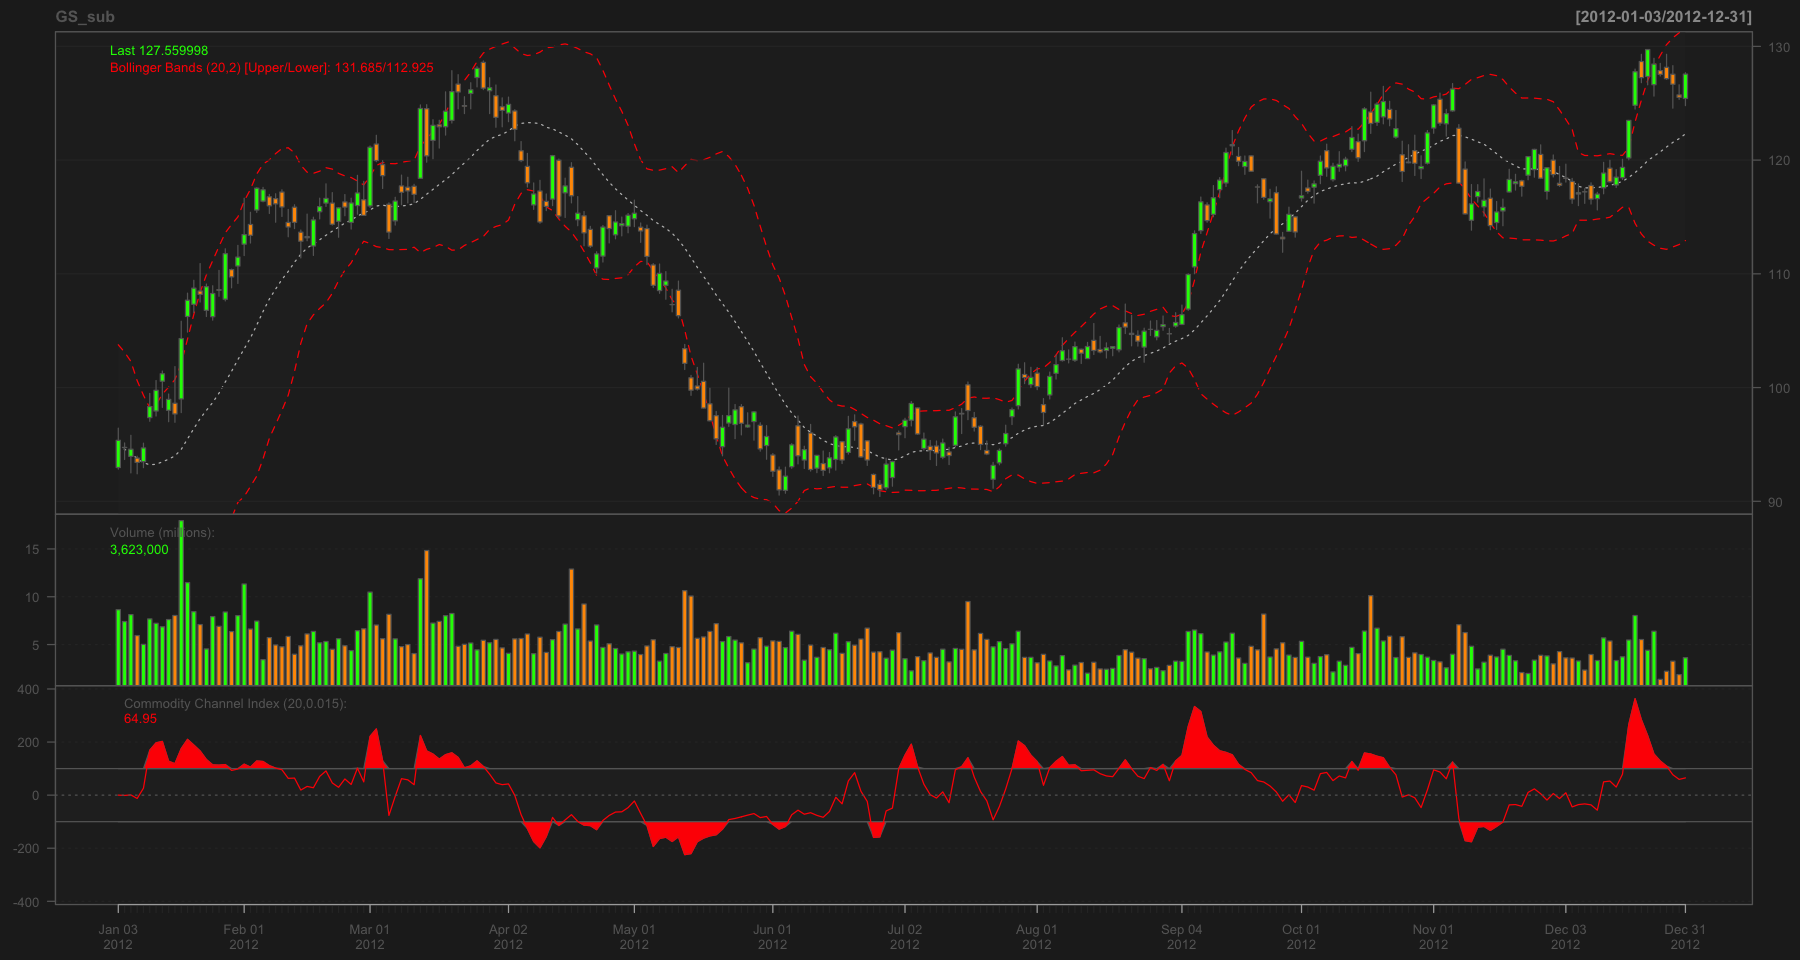

In [3]:
#Charts
chartSeries(GS_sub, subset = "2012",TA = "addVo();addBBands();addCCI()")


Looking at the Moving Average

In [4]:
#Adding 20, 50 and 200 Simple Moving Averages to our Data and Creating a Signal
GS_sub$`20d` <- SMA(GS_sub$GS.Close,n=20)
GS_sub$`50d` <- SMA(GS_sub$GS.Close,n=50)
GS_sub$`200d` <- SMA(GS_sub$GS.Close,n=200)

regime_val <- sigComparison("", data = GS_sub,
                            columns = c("20d", "50d"), relationship = "gt") -
  sigComparison("", data = GS_sub,
                columns = c("20d", "50d"), relationship = "lt")
GS_sub$MA_sig <-ifelse(is.na(diff(regime_val) / 2) ==TRUE,yes=0,no=diff(regime_val) / 2)  #signal where the curves cross each other


Visualizing the Moving Averages

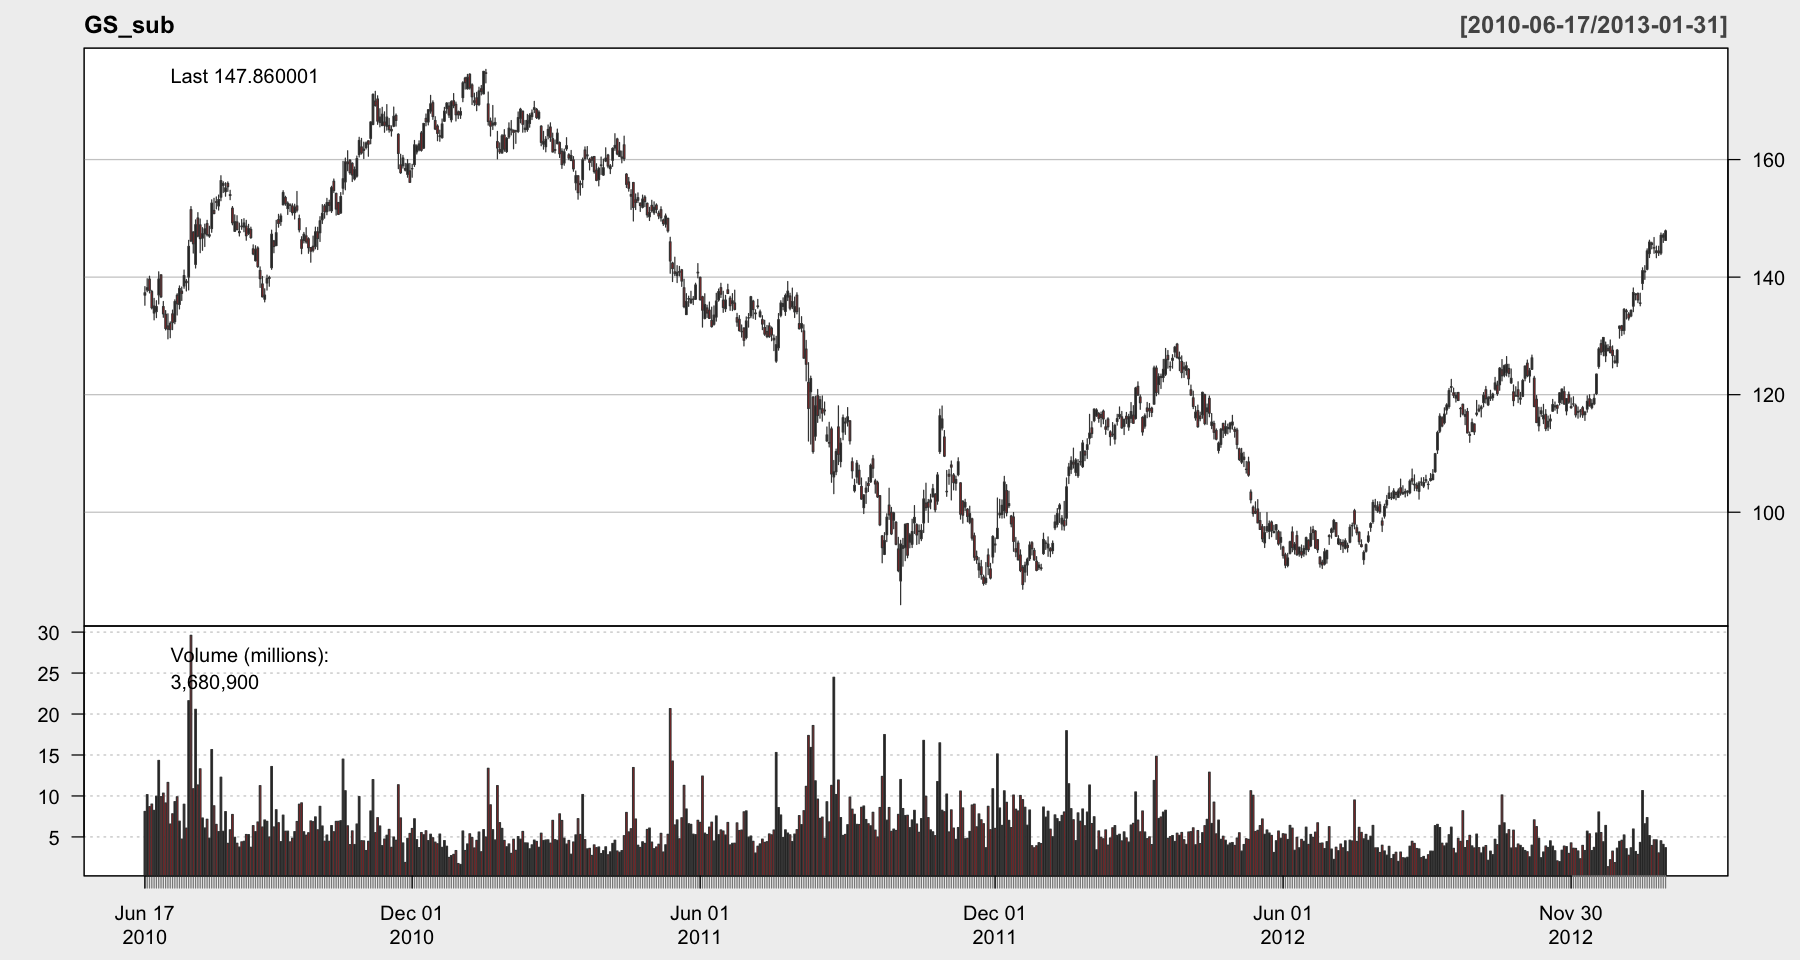

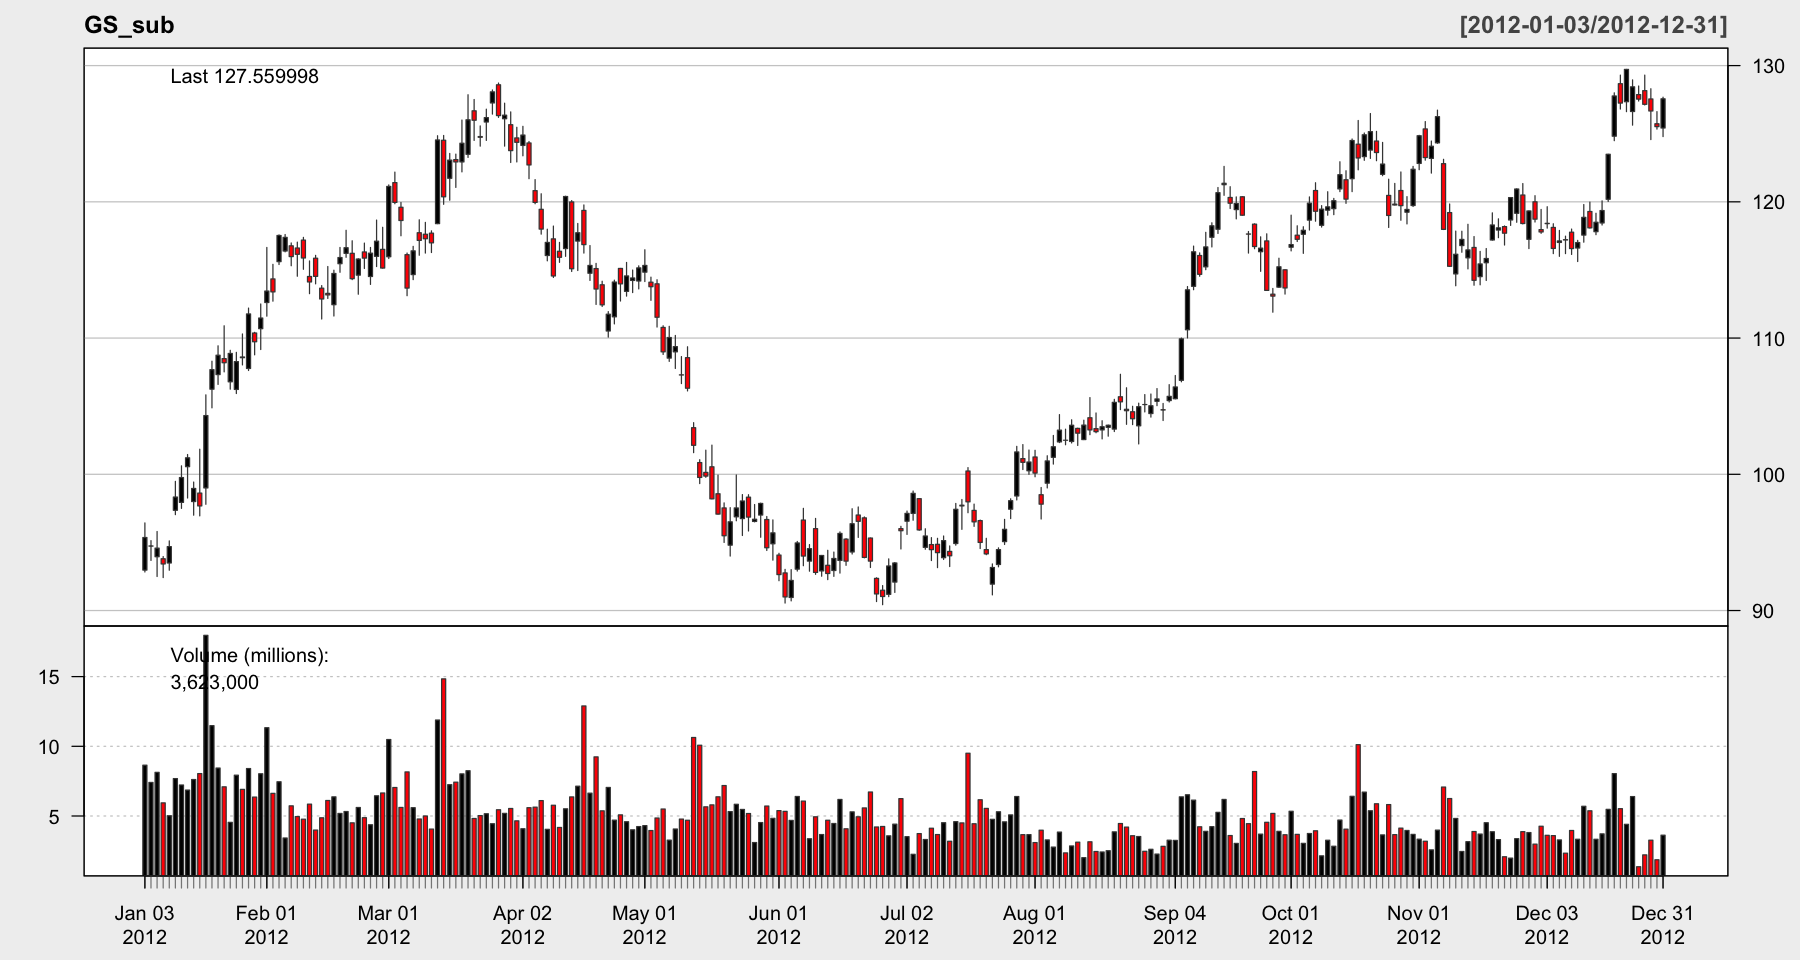

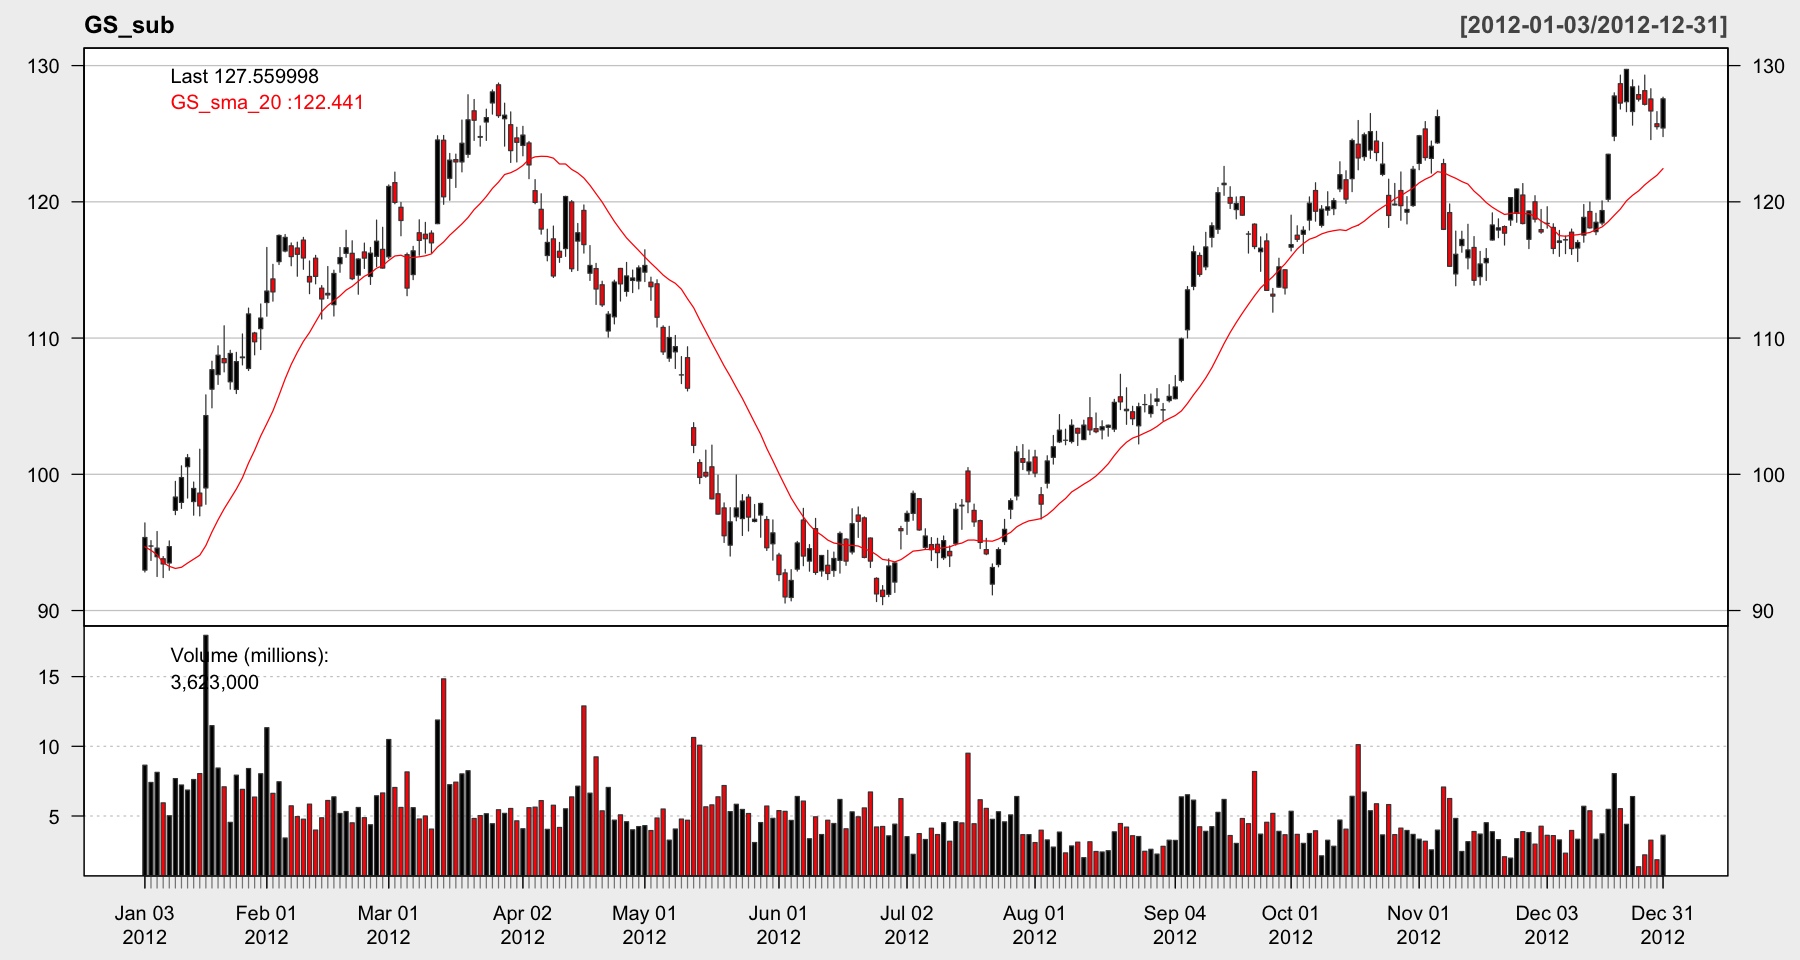

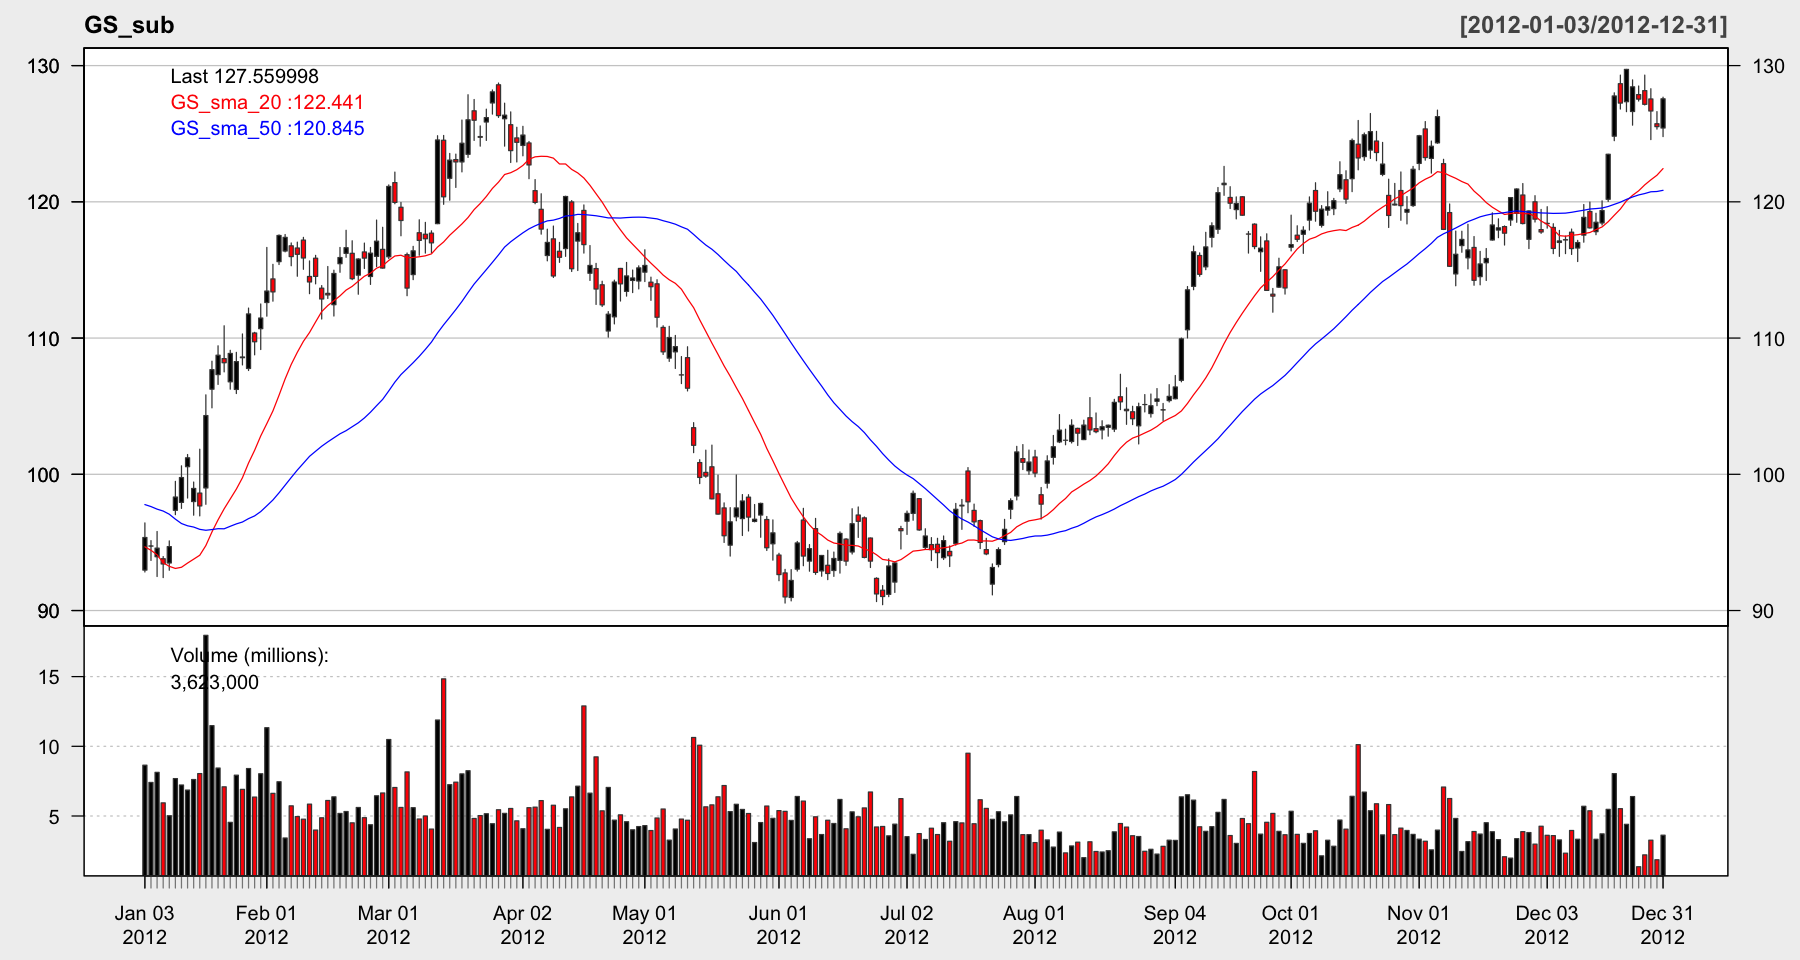

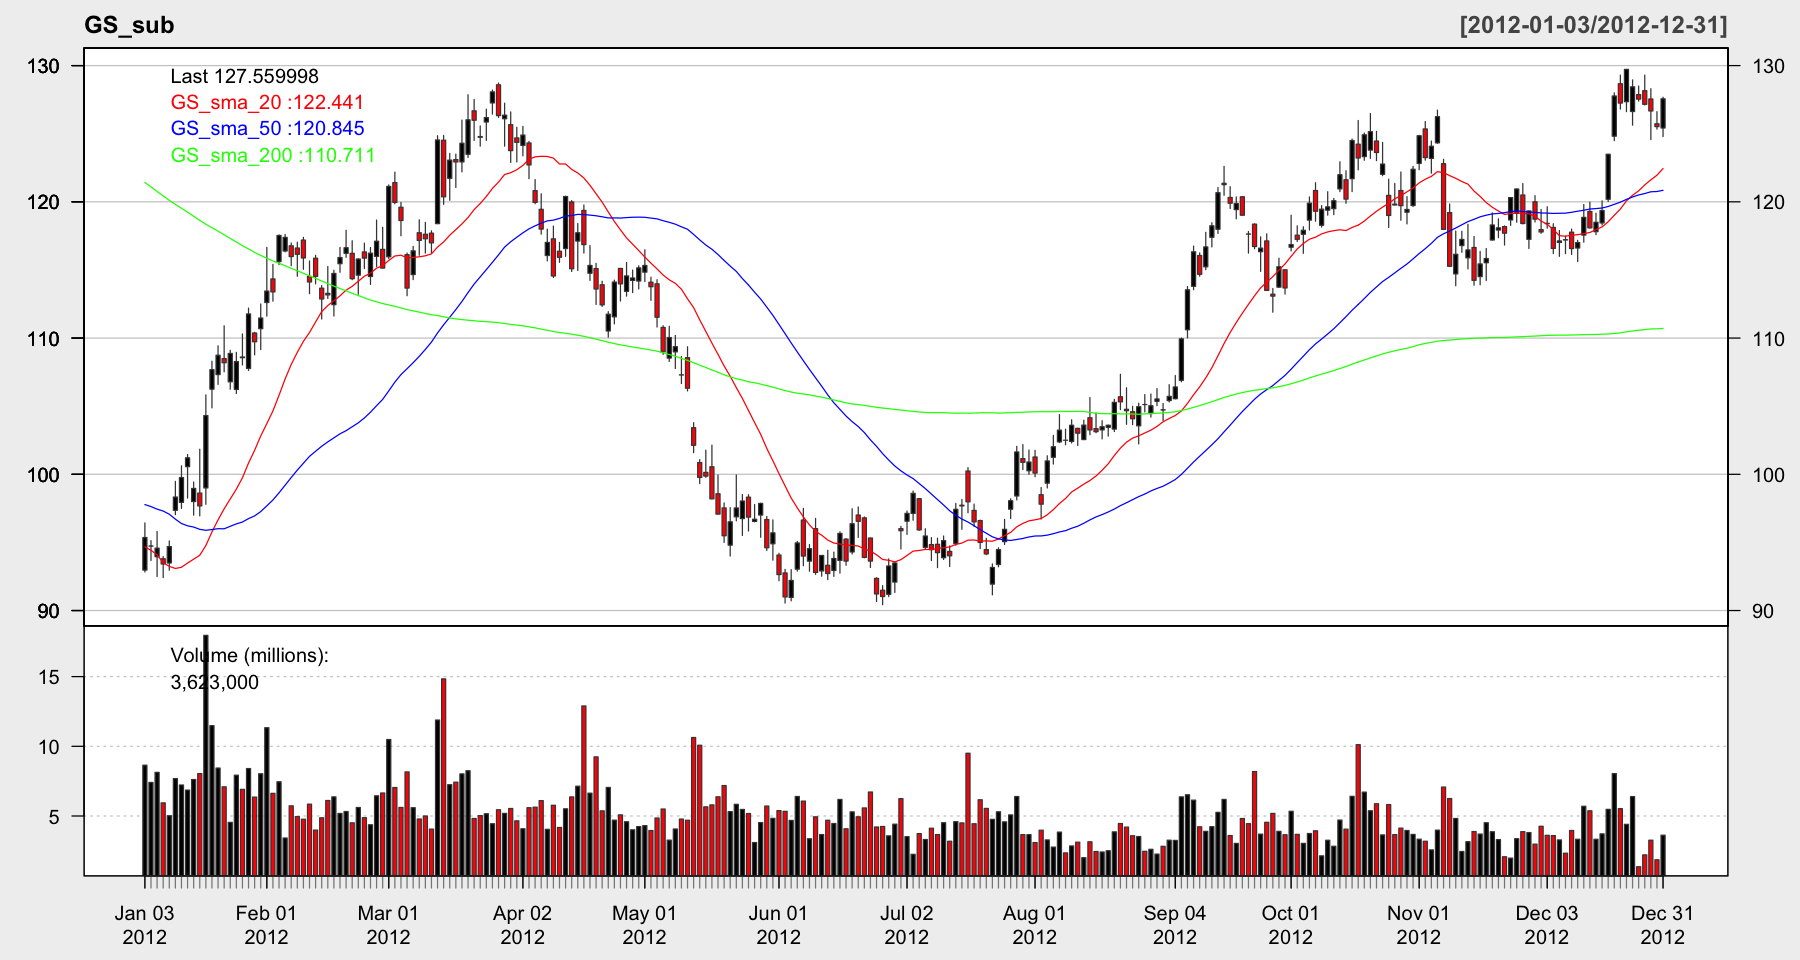

In [5]:
GS_sma_20 <- SMA(
  Cl(GS_sub),  
  n = 20     
)

GS_sma_50 <- SMA(
  Cl(GS_sub),
  n = 50
)

GS_sma_200 <- SMA(
  Cl(GS_sub),
  n = 200
)

candleChart(GS_sub, up.col = "black", dn.col = "red", theme = "white")
zoomChart("2012")  # Zoom into the year 2012 to visualize the behavior
addTA(GS_sma_20, on = 1, col = "red")  
addTA(GS_sma_50, on = 1, col = "blue")
addTA(GS_sma_200, on = 1, col = "green")


Now Lets add the Open-Close, Open-Open and Hi-Close percentage changes to our data

In [6]:
GS_sub$OpCl <- OpCl(GS_sub) #daily percentage change open to close
GS_sub$OpOp <- OpOp(GS_sub) #one period open to open change
GS_sub$HiCl <- HiCl(GS_sub) #the percentage change from high to close
head(GS_sub)


           GS.Open GS.High GS.Low GS.Close GS.Volume GS.Adjusted X20d X50d
2009-09-01  164.80  166.38 159.93   160.17  12446800    139.9114   NA   NA
2009-09-02  160.13  161.44 158.14   158.54  10751500    138.4876   NA   NA
2009-09-03  159.92  162.25 159.55   161.66   8837800    141.2130   NA   NA
2009-09-04  161.54  163.85 161.36   162.97   6220100    142.3573   NA   NA
2009-09-08  165.25  167.25 165.05   167.22  10066300    146.0698   NA   NA
2009-09-09  167.80  170.56 167.16   170.27  10196500    148.7340   NA   NA
           X200d MA_sig         OpCl         OpOp          HiCl
2009-09-01    NA      0 -0.028094690           NA -0.0373242386
2009-09-02    NA      0 -0.009929507 -0.028337366 -0.0179633856
2009-09-03    NA      0  0.010880478 -0.001311478 -0.0036363390
2009-09-04    NA      0  0.008852347  0.010130034 -0.0053707963
2009-09-08    NA      0  0.011921337  0.022966492 -0.0001793662
2009-09-09    NA      0  0.014719910  0.015431183 -0.0017002463

Next, lets gather third party data. Lets bring in insider trading information pulled from:
* [Insider Trading](http://insidertrading.org/)

In [7]:
#Importing the CSV file created from the data pulled
insider_t<-data.table::fread("/Users/luislosada/Columbia Drive/Anomaly Detection/Insider Trading GS.csv") 
sub_insider<-data.frame(insider_date = insider_t$`Transaction Date`,pps_insider = insider_t$`Price per Share`,
                        Total_Value = insider_t$`Total Value`,Trans_Shares = insider_t$`Transaction Shares`,
                        Shares_After_trans = insider_t$`Shares After Transaction`)

#Data needs some cleaning before it is usable
sub_insider$Total_Value<-as.numeric(gsub("\\,", "",gsub("\\$", "", sub_insider$Total_Value)))
sub_insider$pps_insider<-as.numeric(gsub("\\,", "",gsub("\\$", "", sub_insider$pps_insider)))
sub_insider$Trans_Shares<-as.numeric(gsub("\\,", "",sub_insider$Trans_Shares))
sub_insider$Shares_After_trans<-as.numeric(gsub("\\,", "",sub_insider$Shares_After_trans))
sub_insider$insider_date<-as.Date(sub_insider$insider_date,format = "%m/%d/%y")
sub_insider$Perc_Sold = round(sub_insider$Trans_Shares/(sub_insider$Shares_After_trans+sub_insider$Trans_Shares)*100,2)

#Now lets group and organize the data by days so that it can be merged to our dataset
insider_TS<-sub_insider %>%
  group_by(insider_date)%>%
  summarize(pps_insider = mean(pps_insider), Total_Value = sum(Total_Value),
            Trans_Shares = sum(Trans_Shares),Shares_After_trans = sum(Shares_After_trans),
            Avg_Perc_Sold = mean(Perc_Sold))
  
insider_TS<-as.data.frame(insider_TS)
insider_TS<-as.xts(insider_TS[,-1],order.by = insider_TS[,1],dateFormat = "%Y/%m/%d")

#Creating a function in order to match our insider data to our GS Stock dataset
add_insider<-function(df1,df2){
  in_df1<-index(df1)
  in_df2<-index(df2)
  df1$Perc_Sold<- rep(x = NA, times=NROW(df1) )
  df1$insider<- rep(x = F,times=NROW(df1))
  for (i in 1:NROW(df1)){
    for (j in 1:NROW(df2)){
      if (in_df1[i] == in_df2[j]){
        df1$Perc_Sold[i]<- df2$Avg_Perc_Sold[j]
        df1$insider[i] <-TRUE
      }
    }
  }
  return(df1)
  }

GS_Comp<- add_insider(GS_sub,insider_TS)
head(GS_Comp)


           GS.Open GS.High GS.Low GS.Close GS.Volume GS.Adjusted X20d X50d
2009-09-01  164.80  166.38 159.93   160.17  12446800    139.9114   NA   NA
2009-09-02  160.13  161.44 158.14   158.54  10751500    138.4876   NA   NA
2009-09-03  159.92  162.25 159.55   161.66   8837800    141.2130   NA   NA
2009-09-04  161.54  163.85 161.36   162.97   6220100    142.3573   NA   NA
2009-09-08  165.25  167.25 165.05   167.22  10066300    146.0698   NA   NA
2009-09-09  167.80  170.56 167.16   170.27  10196500    148.7340   NA   NA
           X200d MA_sig         OpCl         OpOp          HiCl Perc_Sold
2009-09-01    NA      0 -0.028094690           NA -0.0373242386        NA
2009-09-02    NA      0 -0.009929507 -0.028337366 -0.0179633856        NA
2009-09-03    NA      0  0.010880478 -0.001311478 -0.0036363390        NA
2009-09-04    NA      0  0.008852347  0.010130034 -0.0053707963        NA
2009-09-08    NA      0  0.011921337  0.022966492 -0.0001793662        NA
2009-09-09    NA      0  0.0147

We also want to add earnings data in order to take that into account. Earnings season is always something to take into account when analyzing stock movement as these events usually spark some interest in the stock based on what's reported:

* [NASDAQ Earnings Tool](https://www.nasdaq.com/market-activity/stocks/gs)

In [8]:
#Importing CSV file created by manually pulling data from the NASDAQ site
earnings<-data.table::fread("/Users/luislosada/Columbia Drive/Anomaly Detection/Earnings_GS.csv")
earnings$Date<-as.Date(earnings$Date,format = "%m/%d/%y")
earnings<-as.data.frame(earnings)
earnings_xts<-as.xts(earnings[,-1],order.by = earnings[,1],dateFormat = "%Y/%m/%d")

#Function to ease the merging process
add_earnings<-function(df1,df2){
  in_df1<-index(df1)
  in_df2<-index(df2)
  df1$earnings<- rep(x = FALSE, times=NROW(df1) )
  df1$earnings_behavior<-rep(x = 0, times=NROW(df1) )
  for (i in 1:NROW(df1)){
    for (j in 1:NROW(df2)){
      if (in_df1[i] == in_df2[j]){
        df1$earnings[i]<-TRUE
        df1$earnings[i+1]<-TRUE
        df1$earnings[i-1]<-TRUE
        df1$earnings_behavior[i]<-ifelse(test = df2[j,2] == "Up",yes = 1,no=-1)
      }
    }
  }
  return(df1)
}

GS_Full<-add_earnings(GS_Comp,earnings_xts)

Now the fun part begins. There seems to be a wide variety of methods to identify anomalies within a dataset, however
the isolation forest technique is considered one of the most accurate and fastest way of detecting anomalies. 
What the algorithm does in the backgorund is also easy to understand if you have worked with other tree-based 
algorithms like random forest. Here is a very brief explanation into how it works:
    
    Using a tree based method, the algo looks at instances where the path from the root node
    to the terminating node is shorter than usual. By detecting shorter paths the algo assumes 
    that these instances are anomalies in the data.

A more thorough explantion can be found here:
* [Paper](https://cs.nju.edu.cn/zhouzh/zhouzh.files/publication/tkdd11.pdf)
* [Article](https://towardsdatascience.com/outlier-detection-with-isolation-forest-3d190448d45e)

In [9]:
#Fitting an isolation forest model
iso<- isolationForest$new()
GS_DF<-as.data.frame(GS_Full[-1,c(-7,-8,-9,-10,-14)]) #elimnating variables with NAs
iso$fit(GS_DF)

GS_DF$outlier <- as.factor(ifelse(iso$scores$anomaly_score >=0.65, "outlier", "normal")) #threshold at 0.65
GS_Full<-as.data.frame(GS_Full)
GS_Full<-cbind(GS_Full,outlier = c("normal",as.character(GS_DF$outlier))) #adding the missing first row

head(iso$scores[order(iso$scores$anomaly_score,decreasing = T),])

Building Isolation Forest ... 
done

Computing depth of terminal nodes ... 
done



id,average_depth,anomaly_score
<int>,<dbl>,<dbl>
157,3.02,0.8476648
732,6.15,0.7142232
735,6.57,0.6979943
838,6.78,0.6900187
527,7.15,0.6761875
543,7.39,0.6673645


Next lets identify outliers in the volume using a simple quantiles technique where we identify points that go
beyond the boundaries of the quantiles by 1.5.

In [10]:
#Now outliers in the volume using 1.5x IQR
lowerq = quantile(GS_Full$GS.Volume)[2]
upperq = quantile(GS_Full$GS.Volume)[4]
iqr = upperq - lowerq
mild.threshold.upper = (iqr * 1.5) + upperq
mild.threshold.lower = lowerq - (iqr * 1.5)

GS_Full$Volume_Outlier<-ifelse(GS_Full$GS.Volume > mild.threshold.upper | GS_Full$GS.Volume < mild.threshold.lower, yes = TRUE,no=FALSE)


Lets visualize our data by comparing Volume to OpCl. This will give us an idea of where the outliers are located 
and if high volume has anything to do with volatility.

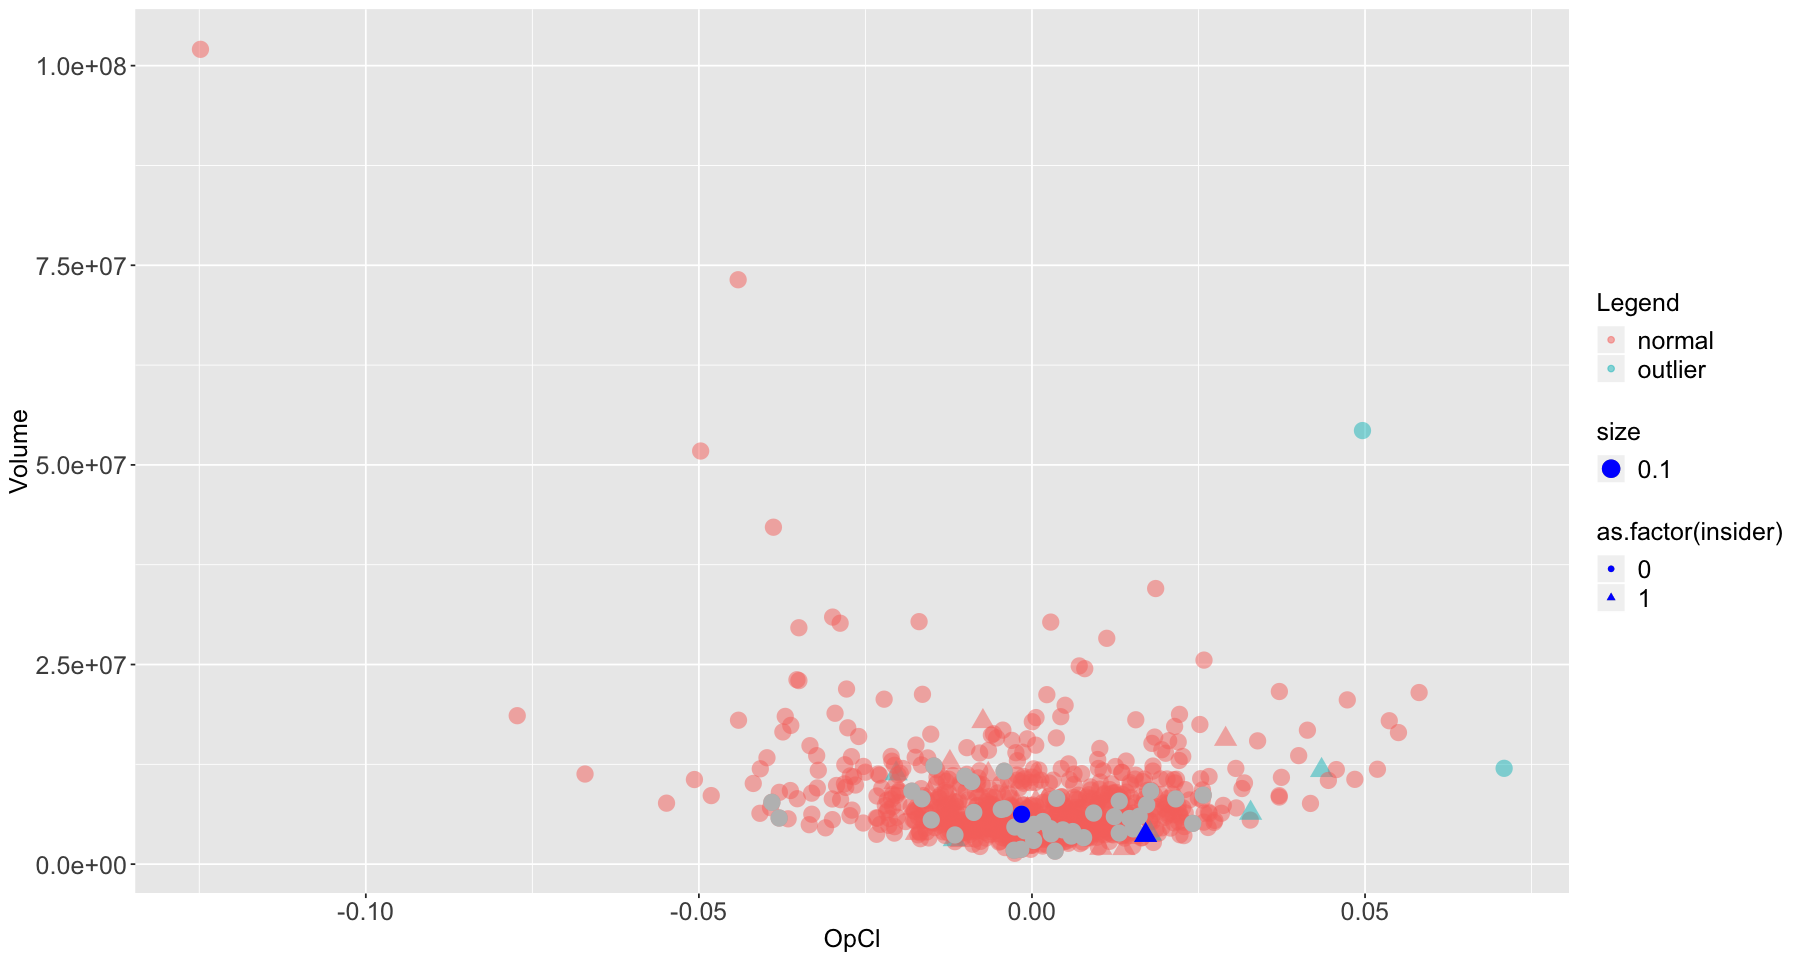

In [11]:
ggplot(GS_Full, aes(x = OpCl , y = GS.Volume, color = outlier,size =0.1)) + 
  geom_point(alpha = 0.5,aes(shape = as.factor(insider))) +
  geom_point(data=GS_Full[which(GS_Full$earnings == 1),], 
             aes(x = OpCl ,y = GS.Volume,shape = as.factor(insider)), colour="grey")+
  geom_point(data=GS_Full[which(GS_Full$earnings == 1 & GS_Full$outlier == 'outlier'),], 
             aes(x = OpCl , y = GS.Volume,shape = as.factor(insider)), colour="blue")+
  labs(x = "OpCl", y = "Volume") +
  labs(alpha = "", colour="Legend")+
  theme(axis.text=element_text(size=15),axis.title=element_text(size=15),legend.text = element_text(size=15),
        legend.title = element_text(size=15))


Finally, after looking at our plot, these points call my attention the most:
    * Points classified as outliers by our iForest algo but that also go into the earnings season schedule
    and have a reported insider trading.
    * Points where the Open Close and Open Open percentage change difference is high. This means that something
    happened during after hours trading that moved the stock.
    * Points where the Slow and Fast Moving Averages get inverted and there's also an abnormal volume of
    trades. The Slow vs Fast moving average trading technique is something very well known by traders but not always
    used as other fundamentals have to be considered. Yet, higher volumes means that the inversion had some abnormal     effect on the stock.

In [12]:
#Finding the points
inspect<-which(GS_Full$earnings == 1 & GS_Full$outlier == 'outlier' & GS_Full$insider == 1 )
inspect2<-which.max(GS_Full$OpCl-GS_Full$OpOp)
inspect3<-which(GS_Full$MA_sig != 0 & GS_Full$Volume_Outlier == TRUE)
A_Score<-iso$scores[c(inspect-1,inspect2-1,inspect3-1),][,"anomaly_score"]

#Creating the Table
x<-cbind(rbind(rbind(GS_Full[inspect,],GS_Full[inspect2,]),GS_Full[inspect3,]),A_Score)%>%
  select("GS.Open","GS.Close","GS.Volume","Volume_Outlier","OpCl","OpOp","anomaly_score","Perc_Sold","earnings","MA_sig")

x<-cbind(x,Why = c("All The Marks","OpCl vs OpOp","MA Sig and Volume"))
colnames(x)<-c("Open","Close","Volume","Is_Outlier","OpCl","OpOp","A Score","% Sold","Earnings","MA Signal","Why")
#Lets take a look at The Suspects
dataTABLE <- 
  hux(x) %>%  
  set_bold(row = 1, col = everywhere, value = TRUE) %>% 
  set_all_borders(TRUE)

dataTABLE

,Open,Close,Volume,Is_Outlier,OpCl,OpOp,A Score,% Sold,Earnings,MA Signal,Why
,<dbl>,<dbl>,<dbl>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
2012-12-31,125.42,127.56,3623000,FALSE,0.01706267,-0.002465641,0.6900187,10.184,1,0,All The Marks
2010-04-19,155.60,163.32,54299200,TRUE,0.04961440,-0.152597700,0.8476648,NA,0,0,OpCl vs OpOp
2010-04-30,151.90,145.20,73187900,TRUE,-0.04410795,-0.047947407,0.5601563,NA,0,-1,MA Sig and Volume


# Conclusion

All three suspects could well be considered as anomalies and should be analyzed but the "All the Marks" observation
seems to be the most conspicous one. To start with, the iforest algo considers it an outlier and if we look at the 
anomaly scores table this observation ranks up fourth. To explain why this observation is considered an outlier lets 
look at the other variables. 

#### Earnings
Earnings season usually means that there is going to be movement for the stock. However, earnings are usually reported at the end of the day and thus the effect is usually seen afterwards. Knowing how the stock is going to perform in the earnings report and reacting to it is the pinacle of most illegal insider tradings transactions. This leads us into the insider trading report for that date.



#### % Sold
This variable calculates the average percentage of the total holdings the indiduals trading that day sold. It seems that, on average, these people sold about 10% of their total holdings. Lets see how this compares to other instances of reported insider trading.

In [13]:
y<-as.data.frame(table(as.factor(insider_t$`Transaction Date`)))
oy<-head(y[order(y$Freq,decreasing = T),],n=NROW(y)*.30)
oy$Var1<-as.Date(oy$Var1,format = "%m/%d/%y")

earnings_to_table<-function(df1,df2){
  in_df1 = as.Date(row.names(df1),tryFormats = c("%Y-%m-%d", "%Y/%m/%d"))
  in_df2 = df2[,1]
  df2$earnings<-rep(x = 0, times=NROW(df2) )
  df2$perc_sold<-rep(x = NA, times=NROW(df2) )
  for (i in 1:NROW(df1)){
    for (j in 1:NROW(df2)){
      if (in_df1[i] == in_df2[j]){
        df2$earnings[j]<- df1$earnings[i]
        df2$perc_sold[j]<- df1$Perc_Sold[i]
      }
    }
  }
  return(df2)
}

earnings_to_table(GS_Full,oy)


,Var1,Freq,earnings,perc_sold
,<date>,<int>,<dbl>,<dbl>
35,2008-03-19,47,0,NA
48,2010-08-11,34,0,4.001176
4,2008-01-25,25,0,NA
10,2012-10-17,19,0,7.303158
36,2008-03-20,18,0,NA
23,2012-11-26,16,0,1.271875
25,2012-11-27,16,0,1.273125
26,2012-11-28,16,0,1.273125
1,2009-01-13,11,0,NA


Frequency and Percentage Sold don't really tell us much here. It seems like it was a completely normal transaction. However, it seems that this is the only instance that such a transaction was allowed so close to an earnings report. This is  our trigger and the reason why this observation has been picked as the number one suspect. 

#### Final Note

It is important to point out that this is not a definite conclusion. Anomaly detection does not only involve machine learning and feature engineering work, it also requires a thorough investigation into the event. What these tools do help with is with narrowing down the observations into events that seem to break the norm and thus facilitate the work of the investigator.